# Continuous latent variable models

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from src.continuous_latent_variables import FactorAnalysis, LinearDynamicalSystem
from src.components import Gaussian, logsumexp

np.random.seed(1)

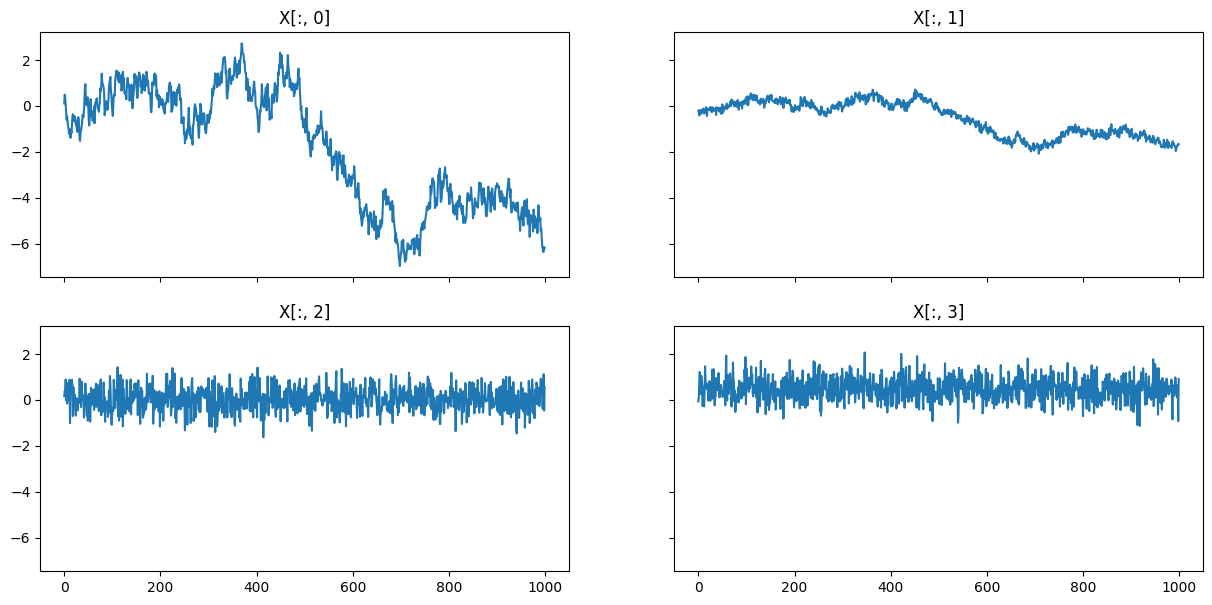

In [2]:
# create sequential data set by hierarchical sampling from a lindear dynamical system
gt_lds = LinearDynamicalSystem(
    A=np.array([[0.8, 1], [0, 0.999]]),
    Gamma=np.diag([0.08, 0.001]),
    C=np.diag([1, 1.5]),
    Sigma=np.diag([0.01, 0.01]),
    mu0=np.zeros(2),
    P0=np.eye(2) * 0.01
)
X = gt_lds.draw(1000)
# add two dimensions which are pure noise
x3 = np.random.randn(1000) * 0.5
x4 = np.random.randn(1000) * 0.5 + 0.5
X = np.concatenate([X, x3[:, None], x4[:, None]], axis=1)

fig, ax = plt.subplots(2, 2, figsize=(15, 7), sharex=True, sharey=True)
ax[0, 0].plot(X[:, 0])
ax[0, 0].set_title("X[:, 0]")
ax[0, 1].plot(X[:, 1])
ax[0, 1].set_title("X[:, 1]")
ax[1, 0].plot(X[:, 2])
ax[1, 0].set_title("X[:, 2]")
ax[1, 1].plot(X[:, 3])
ax[1, 1].set_title("X[:, 3]");

## Factor analysis

See Bishop chapter 12.2.

* assumes i.i.d. observations $\mathbf{x}_n$

* the latent variables $\mathbf{z}_n$ are Gaussian distributed

* the mean of $\mathbf{z}_n$ can be chosen without loss of generality to be zero

* the covariance of $\mathbf{z}_n$ can be chosen without loss of generality to be the identity matrix (more degrees of freedom lead to degeneracies, see Roweis et al.)

* emission distributions are Gaussian

* emission covariance $\Psi$ needs to be constrained to prevent trivial solution $\mathbf{W}=\mathbf{0}$

$$p\left( \mathbf{z}_n \right) = \mathcal{N}\left(\mathbf{z}_n | \mathbf{0}, \mathbf{I}\right)$$

$$p\left( \mathbf{x}_n | \mathbf{z}_n \right) = \mathcal{N}\left(\mathbf{x}_n | \mathbf{W} \mathbf{z}_n + \mathbf{\mu}, \mathbf{\Psi}\right)$$

Log likelihood before fitting: -6349.1980523109605
Log likelihood after fitting factor analysis: -3523.1087086348284


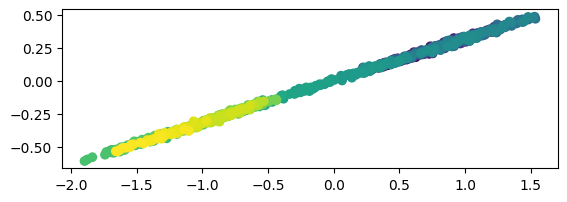

In [3]:
mu = np.mean(X, axis=0)
W = np.eye(X.shape[1], 2)
psi = np.ones(X.shape[1])
fa = FactorAnalysis(
    W=W,
    psi=psi,
    mu=mu
)
print("Log likelihood before fitting: {}".format(fa.log_likelihood(X)))
fa.mle(X)
print("Log likelihood after fitting factor analysis: {}".format(fa.log_likelihood(X)))
Z = fa.e_step(X)[0]
plt.scatter(Z[:, 0], Z[:, 1], c=np.linspace(0, 1, X.shape[0]))
plt.gca().set_aspect('equal')
plt.show()

The latent space of the factor analysis model reveals the correlation in the data.

To obtain probabilistic PCA, we only need to adapt the `m-step` of the factor analysis model slightly, to reflect the isotropic covariance matrix constraint.

Log likelihood after fitting factor analysis: -3523.1087086348284
Log likelihood after fitting probabilistic PCA: -3987.5042256640204


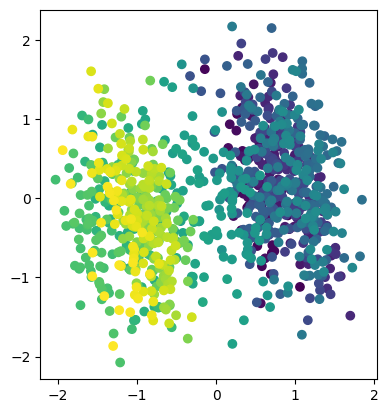

In [4]:
class ProbabilisticPCA(FactorAnalysis):
    def __init__(self, W, sig2, mu):
        self.M = W.shape[1]
        self.W = W
        self.psi = np.ones(W.shape[0]) * sig2
        self.mu = mu

    def m_step(self, X, Ezn, Eznzn):
        self.mu = np.mean(X, axis=0)
        Xc = X - self.mu
        self.W = Xc.T @ Ezn @ np.linalg.pinv(np.sum(Eznzn, axis=0))
        sig2 = np.mean(
            np.mean(Xc**2, axis=1)
            - 2 * np.mean(Ezn @ self.W.T * Xc, axis=1)
            + np.trace((Eznzn @ self.W.T @ self.W).T) / X.shape[1]
        )
        self.psi = np.ones(self.W.shape[0]) * sig2

mu = np.mean(X, axis=0)
W = np.eye(X.shape[1], 2)
sig2 = 1.0
pca = ProbabilisticPCA(
    W=W,
    sig2=sig2,
    mu=mu
)
print("Log likelihood after fitting factor analysis: {}".format(fa.log_likelihood(X)))
pca.mle(X)
print("Log likelihood after fitting probabilistic PCA: {}".format(pca.log_likelihood(X)))
Z = pca.e_step(X)[0]
plt.scatter(Z[:, 0], Z[:, 1], c=np.linspace(0, 1, X.shape[0]))
plt.gca().set_aspect('equal')
plt.show()

Clearly, our data does not fulfill the assumption of isotropic noise.

## Linear dynamical system

See Bishop chapter 13.3.

* can be viewed as extending factor analysis / probabilistic PCA to sequential (non-i.i.d.) data

* latent variables $\mathbf{z}_n$ form a linear-Gaussian Markov chain

* emission distributions are Gaussian

* in contrast to factor analysis, emission distribution has no offset and full covariance

$$p\left( \mathbf{z}_1 \right) = \mathcal{N}\left(\mathbf{z}_1 | \mathbf{\mu}_0, \mathbf{P}_0\right)$$

$$p\left( \mathbf{z}_n | \mathbf{z}_{n-1} \right) = \mathcal{N}\left(\mathbf{z}_n | \mathbf{A} \mathbf{z}_{n-1}, \mathbf{\Gamma}\right)$$

$$p\left( \mathbf{x}_n | \mathbf{z}_n \right) = \mathcal{N}\left(\mathbf{x}_n | \mathbf{C} \mathbf{z}_n, \mathbf{\Sigma}\right)$$

Log likelihood of fitted probabilistic PCA: -3987.5042256640204
Log likelihood of fitted linear dynamical system: -1199.8929042018144


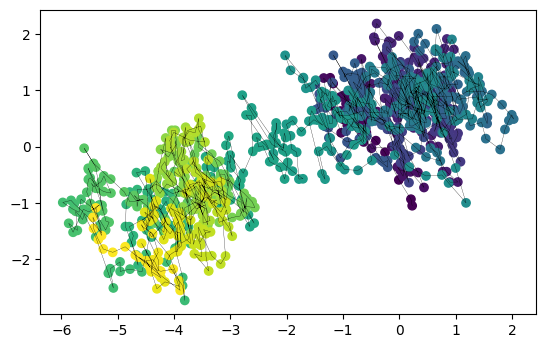

In [5]:
lds = LinearDynamicalSystem(
    C=np.array([[1, 0], [0, 1], [0.5, 0], [0, 0.5]]),
    Sigma=np.eye(4),
    A=np.eye(2),
    Gamma=np.eye(2),
    mu0=np.zeros(2),
    P0=np.eye(2) * 10
)

print("Log likelihood of fitted probabilistic PCA: {}".format(pca.log_likelihood(X)))
lds.mle(X, iter_max=5)
print("Log likelihood of fitted linear dynamical system: {}".format(lds.log_likelihood(X)))
Z = lds.e_step(X)[0]

# because we have an unconstrained covariance matrix in the emission distribution
# the latent space is not as interpretable as for factor analysis and PCA
plt.scatter(Z[:, 0], Z[:, 1], c=np.linspace(0, 1, X.shape[0]))
plt.plot(Z[:, 0], Z[:, 1], "k", linewidth=0.2)
plt.gca().set_aspect('equal')
plt.show()

Linear dynamical systems can be used for online tracking. At each time step $n$, we estimate $\mathbf{\mu}_n$ and $\mathbf{V}_n$, which are the mean and covariance matrix of $p(\mathbf{z}_n | \hat{\mathbf{x}}_1, ..., \hat{\mathbf{x}}_n)$ via Kalman filtering, then apply the emission model to get $p(\mathbf{x}_n | \hat{\mathbf{x}}_1, ..., \hat{\mathbf{x}}_n))$.

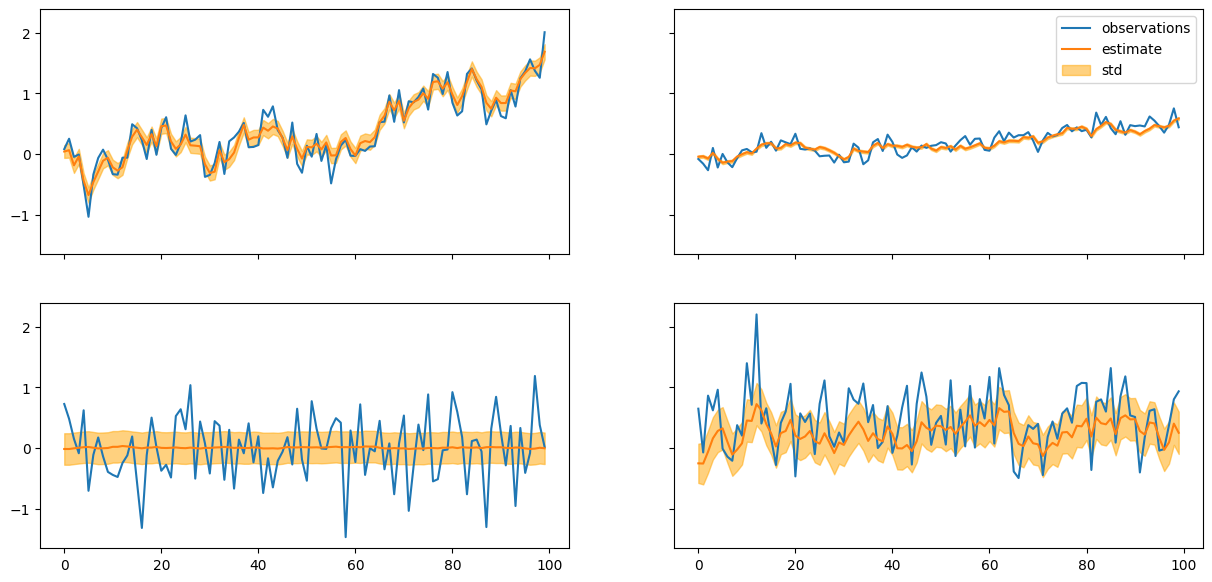

In [6]:
X_test = gt_lds.draw(100)
x3 = np.random.randn(100) * 0.5
x4 = np.random.randn(100) * 0.5 + 0.5
X_test = np.concatenate([X_test, x3[:, None], x4[:, None]], axis=1)

mu, V, _, _ = lds.forward(X_test)
mean = mu @ lds.C.T
cov = lds.Sigma + lds.C @ V @ lds.C.T

# note how our LDS has more difficulty modelling the offset noise 
# (bottom right) because we didn't include an offset/intercept
# in the emission model
fig, ax = plt.subplots(2, 2, figsize=(15, 7), sharex=True, sharey=True)
for i in range(4):
    row, col = divmod(i, 2)
    ax[row, col].plot(X_test[:, i], label="observations")
    ax[row, col].plot(mean[:, i], label="estimate")
    ax[row, col].fill_between(np.arange(len(mean)), mean[:, i] - cov[:, i, i], mean[:, i] + cov[:, i, i], color="orange", alpha=0.5, label="std")
ax[0, 1].legend();

## Extensions

Similarly to the discrete case, continuous latent variable models can be extended by loosening the linearity and/or Gaussianity constraints. However, extensions are not as straightforward in the continuous case, as the model equations quickly become intractable. As an example, variational autoencoders can be viewed as the extension of probabilistic PCA to non-linear transformations.

Here, we illustrate the particle filter (see Bishop chapter 13.3.4.), an extension of the linear dynamical system to non-linearity and/or non-Gaussianity.

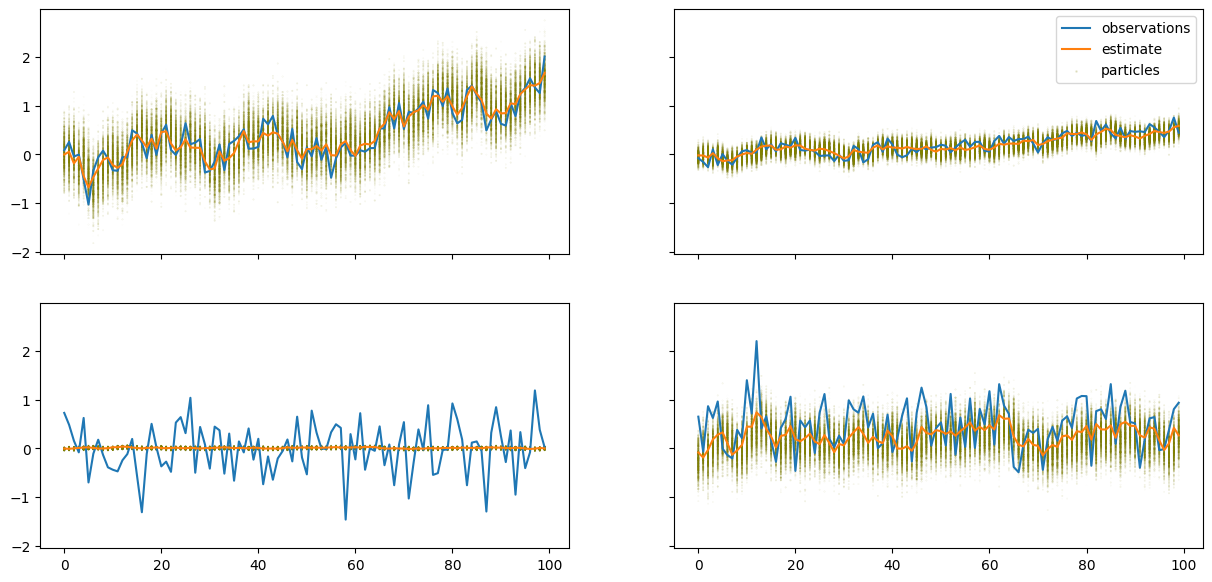

In [7]:
# number of particles
L=1000

# for simplicity we use the same model as in the LDS,
# however for the particle filter we could also choose
# non-linear and/or non-Gaussian models
M, C, Sigma, A, Gamma, mu0, P0 = lds.M, lds.C, lds.Sigma, lds.A, lds.Gamma, lds.mu0, lds.P0

mu = []
particles = []
weights = []
z_prev = np.random.multivariate_normal(mu0, P0, L)
w_prev = np.ones(L) / L
for x_n in X_test:
    # draw L samples from p(z_n | X_{n-1}) (Eq. (13.119)):
    # 1. resample with weights w_prev
    zl = z_prev[np.random.choice(L, L, p=w_prev)]
    # 2. state transition
    z_n = zl @ A.T + np.random.multivariate_normal(np.zeros(M), Gamma, L)
    # evaluate the weights w_n^(l) using emission density
    log_w_n = Gaussian(z_n @ C.T, Sigma).log_pdf(x_n)
    log_w_n -= logsumexp(log_w_n)  # Eq. (13.118)
    w_n = np.exp(log_w_n)
    mu.append(np.average(z_n, axis=0, weights=w_n))  # Eq. (13.117)
    particles.append(z_n)
    weights.append(w_n)
    z_prev, w_prev = z_n, w_n
mu = np.asarray(mu)
particles = np.asarray(particles)
weights = np.asarray(weights)

# remap from latent to observation
mean = mu @ C.T
pp = particles @ C.T

fig, ax = plt.subplots(2, 2, figsize=(15, 7), sharex=True, sharey=True)
x_grid = np.arange(len(mean))
for i in range(4):
    row, col = divmod(i, 2)
    ax[row, col].plot(X_test[:, i], label="observations")
    ax[row, col].plot(mean[:, i], label="estimate")
    ax[row, col].scatter(np.tile(x_grid, (1, L)).ravel(), pp[:, :, i].T, s=weights * 50, alpha=0.15, label="particles", c='olive')
ax[0, 1].legend();